In [1]:
# Import Dependencies

import csv
import json
import random
import sys
import time
import uuid
from collections import defaultdict
from pathlib import Path

import boto3
import botocore
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from botocore.exceptions import ClientError
from packaging import version

%matplotlib inline

# Setup Clients

personalize = boto3.client("personalize")
personalize_runtime = boto3.client("personalize-runtime")
personalize_events = boto3.client("personalize-events")

servicediscovery = boto3.client("servicediscovery")
ssm = boto3.client("ssm")

In [2]:
users_filename = "data/users.csv"
items_filename = "data/items.csv"
interactions_filename = "data/interactions.csv"

bucket = "spent-service-personalize-datasets"
print("Bucket: {}".format(bucket))

Bucket: spent-service-personalize-datasets


In [3]:
users_df = pd.read_csv(users_filename)
users_df.head()

,USER_ID,AGE,GENDER
0,1,31,M
1,2,58,F
2,3,43,M
3,4,38,M
4,5,24,M


In [4]:
items_df = pd.read_csv(items_filename)
items_df.head()

,ITEM_ID,CATEGORY
0,42aaa8f7-b5a5-467e-b2c1-b02015c99426,การศึกษา
1,33fc5477-fd95-4fe1-b22c-62c71c407941,การศึกษา
2,afb14043-869a-479e-902f-f3706f6f2f57,การศึกษา
3,b7353a81-9472-4c88-975a-0fd1f9d47cbd,การศึกษา
4,ec8c9eb8-75ac-4d2e-8ef1-99bb8bc23055,การศึกษา


In [5]:
interactions_df = pd.read_csv(interactions_filename)
interactions_df.head()

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP
0,d38dd892-1811-4c72-a4e0-7aa3f38d0213,198,news_viewed,1612599851
1,d38dd892-1811-4c72-a4e0-7aa3f38d0213,198,news_viewed,1612599851
2,5fa995f7-3521-49de-bad7-1582264f143d,216,news_viewed,1612599875
3,5fa995f7-3521-49de-bad7-1582264f143d,216,news_viewed,1612599875
4,0b26e565-a251-4410-bff5-f20920d9435b,133,news_viewed,1612599919


In [6]:
items_raw_df = pd.read_csv("data/items_raw.csv")
items_raw_df.head()

,id,source,pubDate,url,image,title,summary,category,tags,raw_html_content
0,42aaa8f7-b5a5-467e-b2c1-b02015c99426,มติชน,2021-01-12T07:06:07Z,https://www.matichon.co.th/news-monitor/news_2...,https://www.matichon.co.th/wp-content/uploads/...,‘ณัฏฐพล’ ถกสำนักงบฯ เร่งผลักดันโครงการพัฒนาร.ร...,‘ณัฏฐพล’ ถกสำนักงบฯ เร่งผลักดันโครงการพัฒนาร.ร...,การศึกษา,NaN,"<div class=""td-post-content"">\n\n\n <h2>‘ณัฏฐ..."
1,33fc5477-fd95-4fe1-b22c-62c71c407941,มติชน,2021-01-29T07:42:43+00:00,https://www.matichon.co.th/education/news_2552500,https://www.matichon.co.th/wp-content/uploads/...,มทร.อีสาน ปลื้มแชมป์กลุ่มราชมงคล 2 ปีซ้อน,มทร.อีสาน ปลื้มแชมป์กลุ่มราชมงคล 2 ปีซ้อน,การศึกษา,มทร.อีสาน,"<div class=""td-post-content"">\n\n\n <h4><stro..."
2,afb14043-869a-479e-902f-f3706f6f2f57,มติชน,2021-01-12T01:37:47Z,https://www.matichon.co.th/news-monitor/news_2...,https://www.matichon.co.th/wp-content/uploads/...,กสศ.เร่งจัดแพ็คเกจการเรียนรู้ ช่วยเด็กเยาวชนด้...,กสศ.เร่งจัดแพ็คเกจการเรียนรู้ ช่วยเด็กเยาวชนด้...,การศึกษา,NaN,"<div class=""td-post-content"">\n\n\n <h2><stro..."
3,b7353a81-9472-4c88-975a-0fd1f9d47cbd,มติชน,2021-01-29T07:45:31+00:00,https://www.matichon.co.th/education/news_2553069,https://www.matichon.co.th/wp-content/uploads/...,ก.พ.อ.เห็นชอบเพิ่มช่องขอ ‘ศ.’ ตั้ง ‘บวรศักดิ์...,ก.พ.อ.เห็นชอบเพิ่มช่องขอ ‘ศ.’ ตั้ง ‘บวรศักดิ์...,การศึกษา,NaN,"<div class=""td-post-content"">\n\n\n <h5><span..."
4,ec8c9eb8-75ac-4d2e-8ef1-99bb8bc23055,มติชน,2021-01-27T10:39:37+00:00,https://www.matichon.co.th/education/religious...,https://www.matichon.co.th/wp-content/uploads/...,พระราชทานสัญญาบัตรตั้งสมณศักดิ์ ‘พระราชปริยัติ...,พระราชทานสัญญาบัตรตั้งสมณศักดิ์ ‘พระราชปริยัติ...,การศึกษา,NaN,"<div class=""td-post-content"">\n\n\n <p>วันที่..."


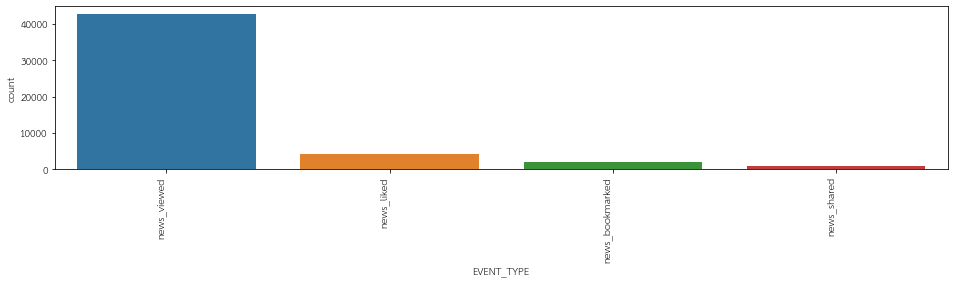

In [191]:
categorical_attributes = interactions_df.select_dtypes(include=["object"])

plt.figure(figsize=(16, 3))
chart = sns.countplot(data=categorical_attributes, x="EVENT_TYPE")
plt.xticks(rotation=90, horizontalalignment="right")
plt.show()

In [192]:
# !wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [193]:
mpl.font_manager.fontManager.addfont("thsarabunnew-webfont.ttf")
mpl.rc("font", family="TH Sarabun New")

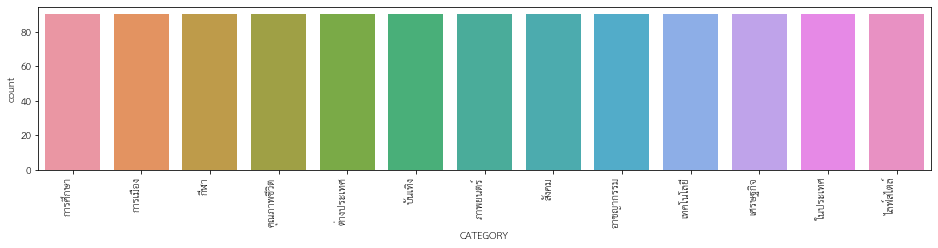

In [194]:
plt.figure(figsize=(16, 3))
chart = sns.countplot(data=items_df, x="CATEGORY")
plt.xticks(rotation=90, horizontalalignment="right")
plt.show()

In [195]:
items_df.groupby("CATEGORY").count()

,ITEM_ID
CATEGORY,
การศึกษา,90
การเมือง,90
กีฬา,90
คุณภาพชีวิต,90
ต่างประเทศ,90
บันเทิง,90
ภาพยนตร์,90
สังคม,90
อาชญากรรม,90


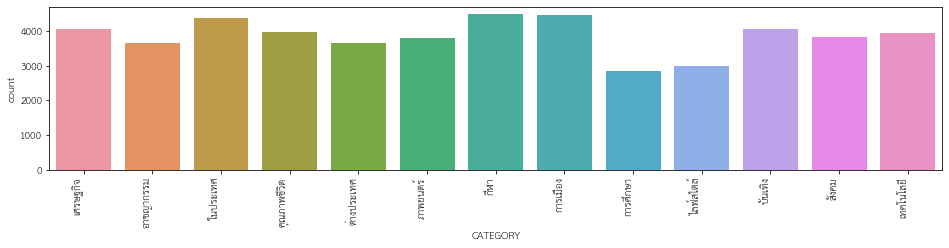

In [196]:
merged_df = interactions_df.astype({"ITEM_ID": str}).merge(
    items_df, left_on="ITEM_ID", right_on="ITEM_ID"
)
merged_df
# plot_df = merged_df.groupby(["category"]).apply(set)
plt.figure(figsize=(16, 3))
chart = sns.countplot(data=merged_df, x="CATEGORY")
plt.xticks(rotation=90, horizontalalignment="right")
plt.show()

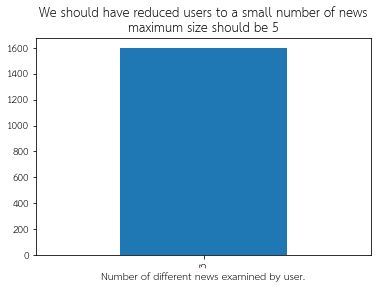

In [199]:
merged_df = (
    interactions_df[["ITEM_ID", "USER_ID"]]
    .astype({"ITEM_ID": str})
    .merge(items_df, left_on="ITEM_ID", right_on="ITEM_ID")
)
plot_df = merged_df.groupby(["USER_ID", "CATEGORY"]).apply(set)
plot_df.apply(len).value_counts().sort_index().plot.bar()
plt.xlabel("Number of different news examined by user.")
plt.title(
    f"We should have reduced users to a small number of news\n"
    f"maximum size should be {4+1}"
)
# The peak at 1 is the male jewellery - there is only one product
plt.show()

<AxesSubplot:>

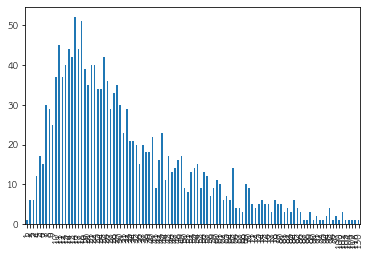

In [264]:
merged_df = (
    interactions_df[["ITEM_ID", "USER_ID"]]
    .astype({"ITEM_ID": str})
    .merge(items_df, left_on="ITEM_ID", right_on="ITEM_ID")
)
plot_df = merged_df[['USER_ID', 'CATEGORY']].groupby(["USER_ID", 'CATEGORY']).apply(set)
test_df = merged_df[['USER_ID', 'CATEGORY']].groupby(["USER_ID", 'CATEGORY'])
test_df.apply(len).value_counts().sort_index().plot.bar()
# plot_df.apply(len).value_counts().sort_index().plot.bar()
# plt.xlabel("Number of different category examined by user.")
# plt.title(
#     f"We should have reduced users to a small number of news\n"
#     f"maximum size should be {4+1}"
# )
# # The peak at 1 is the male jewellery - there is only one product
# plt.show()

In [265]:
interactions_df.groupby("ITEM_ID")["USER_ID"].count()

ITEM_ID
006fb86a-cfed-448a-aaa5-972b237505b3    57
00eec793-b3ae-433f-bb13-9a92183e6013    52
0167ee85-90aa-440f-b44b-ea91514be723    65
022069fd-0efc-4716-a426-e9b2df41d77c    61
02349f27-48cf-47d4-83a4-4f44d064414f    38
                                        ..
fea104c2-00b6-4b92-835f-4721e5fb6020    39
fea5a69e-bdaf-40e3-b952-9ef0c89f8b40    39
ff34a8ef-bfe0-4c8f-92b1-b7a7a8aaf994    67
ff6ed48d-8a3f-49b2-bc66-d348a216fe97    38
ffa02fe6-4f64-4b1b-8b4f-63f2f09a87d4    29
Name: USER_ID, Length: 1166, dtype: int64

In [266]:
interactions_df.groupby("USER_ID").count()

,ITEM_ID,EVENT_TYPE,TIMESTAMP
USER_ID,,,
1,127,127,127
2,111,111,111
3,110,110,110
4,136,136,136
5,123,123,123
...,...,...,...
396,147,147,147
397,170,170,170
398,115,115,115


In [267]:
# merged_df = interactions_df[['ITEM_ID', 'USER_ID']].astype({'ITEM_ID': str}).merge(items_df, left_on='ITEM_ID', right_on='ITEM_ID')[['ITEM_ID', 'CATEGORY', 'USER_ID']]
# plot_df = merged_df.groupby(['ITEM_ID', 'CATEGORY'])['USER_ID'].count()
# plot_df.unstack().plot.barh(figsize=[8, 16])
# plt.title('Balance over products with category coded.')
# plt.show()

In [268]:
plot_df.count()

1596

In [269]:
s3 = boto3.resource("s3")

In [270]:
s3.create_bucket(
    Bucket=bucket,
    CreateBucketConfiguration={
        "LocationConstraint": "ap-southeast-1",
    },
)

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

In [271]:
boto3.Session().resource("s3").Bucket(bucket).Object(users_filename).upload_file(
    users_filename
)

In [272]:
boto3.Session().resource("s3").Bucket(bucket).Object(items_filename).upload_file(
    items_filename
)

In [273]:
boto3.Session().resource("s3").Bucket(bucket).Object(interactions_filename).upload_file(
    interactions_filename
)

## Configure Amazon Personalize

Now that we've prepared our three datasets and uploaded them to S3 we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.

If Personalize was enabled when you deployed the demo, the below logic was run by polling AWS Lambda function whose code is in the file `src/aws-lambda/personalize-pre-create-campaigns/personalize-pre-create-campaigns.py`.

### Create Schemas for Datasets

Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format.

Let's define and create schemas in Personalize for our datasets.

In [7]:
items_schema_name = "spent-personalize-schema-items"
users_schema_name = "spent-personalize-schema-users"
interactions_schema_name = "spent-personalize-schema-interactions"

In [275]:
# personalize.delete_schema(schemaArn='arn:aws:personalize:ap-southeast-1:268400237357:schema/' + items_schema_name)
# personalize.delete_schema(schemaArn='arn:aws:personalize:ap-southeast-1:268400237357:schema/' + users_schema_name)
# personalize.delete_schema(schemaArn='arn:aws:personalize:ap-southeast-1:268400237357:schema/' + interactions_schema_name)

In [276]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {"name": "ITEM_ID", "type": "string"},
        {
            "name": "CATEGORY",
            "type": "string",
            "categorical": True,
        },
        #         {
        #             "name": "TAGS",
        #             "type": ["string", "null"],
        #         },
    ],
    "version": "1.0",
}

try:
    create_schema_response = personalize.create_schema(
        name=items_schema_name, schema=json.dumps(items_schema)
    )
    items_schema_arn = create_schema_response["schemaArn"]
    print(json.dumps(create_schema_response, indent=2))

except personalize.exceptions.ResourceAlreadyExistsException:
    print("You aready created this schema, seemingly")
    schemas = personalize.list_schemas(maxResults=100)["schemas"]
    for schema_response in schemas:
        if schema_response["name"] == items_schema_name:
            items_schema_arn = schema_response["schemaArn"]
            print(f"Using existing schema: {items_schema_arn}")

You aready created this schema, seemingly
Using existing schema: arn:aws:personalize:ap-southeast-1:268400237357:schema/spent-personalize-schema-items


In [277]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {"name": "USER_ID", "type": "string"},
        {"name": "AGE", "type": "int"},
        {
            "name": "GENDER",
            "type": "string",
        },
    ],
    "version": "1.0",
}

try:
    create_schema_response = personalize.create_schema(
        name=users_schema_name, schema=json.dumps(users_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    users_schema_arn = create_schema_response["schemaArn"]

except personalize.exceptions.ResourceAlreadyExistsException:
    print("You aready created this schema, seemingly")
    schemas = personalize.list_schemas(maxResults=100)["schemas"]
    for schema_response in schemas:
        if schema_response["name"] == users_schema_name:
            users_schema_arn = schema_response["schemaArn"]
            print(f"Using existing schema: {users_schema_arn}")

You aready created this schema, seemingly
Using existing schema: arn:aws:personalize:ap-southeast-1:268400237357:schema/spent-personalize-schema-users


In [278]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {"name": "ITEM_ID", "type": "string"},
        {"name": "USER_ID", "type": "string"},
        {"name": "EVENT_TYPE", "type": "string"},
        {"name": "TIMESTAMP", "type": "long"},
    ],
    "version": "1.0",
}

try:
    create_schema_response = personalize.create_schema(
        name=interactions_schema_name, schema=json.dumps(interactions_schema)
    )
    print(json.dumps(create_schema_response, indent=2))
    interactions_schema_arn = create_schema_response["schemaArn"]
except personalize.exceptions.ResourceAlreadyExistsException:
    print("You aready created this schema, seemingly")
    schemas = personalize.list_schemas(maxResults=100)["schemas"]
    for schema_response in schemas:
        if schema_response["name"] == interactions_schema_name:
            interactions_schema_arn = schema_response["schemaArn"]
            print(f"Using existing schema: {interactions_schema_arn}")

You aready created this schema, seemingly
Using existing schema: arn:aws:personalize:ap-southeast-1:268400237357:schema/spent-personalize-schema-interactions


### Create Dataset Group

Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [8]:
dataset_group_name = "spent-8"
items_dataset_name = "spent-personalize-dataset-items"
users_dataset_name = "spent-personalize-dataset-users"
interactions_dataset_name = "spent-personalize-dataset-interactions"

In [280]:
create_dataset_group_response = personalize.create_dataset_group(
    name=dataset_group_name
)

dataset_group_arn = create_dataset_group_response["datasetGroupArn"]
print(json.dumps(create_dataset_group_response, indent=2))

print(f"DatasetGroupArn = {dataset_group_arn}")

{
  "datasetGroupArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset-group/spent-8",
  "ResponseMetadata": {
    "RequestId": "45df1db9-a54e-42d6-81df-a78ab117b562",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:47:40 GMT",
      "x-amzn-requestid": "45df1db9-a54e-42d6-81df-a78ab117b562",
      "content-length": "91",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:ap-southeast-1:268400237357:dataset-group/spent-8


In [281]:
status = None
max_time = time.time() + 3 * 60 * 60  # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn=dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))

    if status == "ACTIVE" or status == "CREATE FAILED":
        break

    time.sleep(15)

DatasetGroup: ACTIVE


## Create Items Dataset

In [282]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name=items_dataset_name,
    datasetType=dataset_type,
    datasetGroupArn=dataset_group_arn,
    schemaArn=items_schema_arn,
)

items_dataset_arn = create_dataset_response["datasetArn"]
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-8/ITEMS",
  "ResponseMetadata": {
    "RequestId": "295cf443-e6af-4888-986a-9d14d5424c48",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:47:44 GMT",
      "x-amzn-requestid": "295cf443-e6af-4888-986a-9d14d5424c48",
      "content-length": "86",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Create Users Dataset

In [283]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name=users_dataset_name,
    datasetType=dataset_type,
    datasetGroupArn=dataset_group_arn,
    schemaArn=users_schema_arn,
)

users_dataset_arn = create_dataset_response["datasetArn"]
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-8/USERS",
  "ResponseMetadata": {
    "RequestId": "bf57a02c-b50f-472c-a235-60c0a469c758",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:47:44 GMT",
      "x-amzn-requestid": "bf57a02c-b50f-472c-a235-60c0a469c758",
      "content-length": "86",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Create Interactions Dataset

In [284]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name=interactions_dataset_name,
    datasetType=dataset_type,
    datasetGroupArn=dataset_group_arn,
    schemaArn=interactions_schema_arn,
)

interactions_dataset_arn = create_dataset_response["datasetArn"]
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-8/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "aa114cef-c835-4bc0-abf9-2492e7529671",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:47:46 GMT",
      "x-amzn-requestid": "aa114cef-c835-4bc0-abf9-2492e7529671",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Import Datasets to Personalize

Up to this point we have generated CSVs containing data for our users, items, and interactions and staged them in an S3 bucket. We also created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

### Setup Permissions

By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

#### Attach policy to S3 bucket

In [285]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {"Service": "personalize.amazonaws.com"},
            "Action": ["s3:GetObject", "s3:ListBucket"],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket),
            ],
        }
    ],
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy));

#### Create S3 Read Only Access Role

In [286]:
iam = boto3.client("iam")

role_name = "Spent" + "-PersonalizeS3-" + dataset_group_name
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {"Service": "personalize.amazonaws.com"},
            "Action": "sts:AssumeRole",
        }
    ],
}

try:
    create_role_response = iam.create_role(
        RoleName=role_name,
        AssumeRolePolicyDocument=json.dumps(assume_role_policy_document),
    )

except iam.exceptions.EntityAlreadyExistsException as e:
    print("Warning: role already exists:", e)
    create_role_response = iam.get_role(RoleName=role_name)

role_arn = create_role_response["Role"]["Arn"]

print("IAM Role: {}".format(role_arn))

attach_response = iam.attach_role_policy(
    RoleName=role_name, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
)

role_arn = create_role_response["Role"]["Arn"]

# Pause to allow role to be fully consistent
time.sleep(30)
print("Done.")

IAM Role: arn:aws:iam::268400237357:role/Spent-PersonalizeS3-spent-8
Done.


### Create Import Jobs

With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three and then wait for them all to complete.

#### Create Items Dataset Import Job

In [287]:
items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName=dataset_group_name + "spent-dataset-items-import",
    datasetArn=items_dataset_arn,
    dataSource={"dataLocation": "s3://{}/{}".format(bucket, items_filename)},
    roleArn=role_arn,
)

items_dataset_import_job_arn = items_create_dataset_import_job_response[
    "datasetImportJobArn"
]
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset-import-job/spent-8spent-dataset-items-import",
  "ResponseMetadata": {
    "RequestId": "db6d3f23-818b-40de-8db3-4c5193506036",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:48:23 GMT",
      "x-amzn-requestid": "db6d3f23-818b-40de-8db3-4c5193506036",
      "content-length": "126",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [288]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName=dataset_group_name + "spent-dataset-users-import",
    datasetArn=users_dataset_arn,
    dataSource={"dataLocation": "s3://{}/{}".format(bucket, users_filename)},
    roleArn=role_arn,
)

users_dataset_import_job_arn = users_create_dataset_import_job_response[
    "datasetImportJobArn"
]
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset-import-job/spent-8spent-dataset-users-import",
  "ResponseMetadata": {
    "RequestId": "987e0fe6-f26e-46e9-94c1-90328e4cb9cf",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:48:23 GMT",
      "x-amzn-requestid": "987e0fe6-f26e-46e9-94c1-90328e4cb9cf",
      "content-length": "126",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [289]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName=dataset_group_name + "spent-dataset-interactions-import",
    datasetArn=interactions_dataset_arn,
    dataSource={"dataLocation": "s3://{}/{}".format(bucket, interactions_filename)},
    roleArn=role_arn,
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response[
    "datasetImportJobArn"
]
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-southeast-1:268400237357:dataset-import-job/spent-8spent-dataset-interactions-import",
  "ResponseMetadata": {
    "RequestId": "0ed85696-23cb-4c7b-911d-48aed8c821d0",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 08:48:25 GMT",
      "x-amzn-requestid": "0ed85696-23cb-4c7b-911d-48aed8c821d0",
      "content-length": "133",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Wait for Import Job to Complete

In [290]:
%%time

import_job_arns = [
    items_dataset_import_job_arn,
    users_dataset_import_job_arn,
    interactions_dataset_import_job_arn,
]

max_time = time.time() + 3 * 60 * 60  # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn=job_arn
        )
        status = import_job_response["datasetImportJob"]["status"]

        if status == "ACTIVE":
            print(f"Import job {job_arn} successfully completed")
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f"Import job {job_arn} failed")
            if import_job_response.get("failureReason"):
                print("   Reason: " + import_job_response["failureReason"])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print("At least one dataset import job still in progress")
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:ap-southeast-1:268400237357:dataset-import-job/spent-8spent-dataset-interactions-import successfully completed
At least one dataset import job still in progress
Import job arn:aws:personalize:ap-southeast-1:268400237357:dataset-import-job/spent-8spent-dataset-users-imp

## Create Solutions

With our three datasets imported into our dataset group, we can now turn to training models. As a reminder, we will be training three models in this workshop to support four different personalization use-cases wth three different models. One model will be used to make related product recommendations on the product detail view/page, another model will be used to make personalized product recommendations to users on the homepage, and the last model will be used to rerank product lists on the category and featured products page. This last model will be repurposed to offer discounts to users. In Amazon Personalize, training a model involves creating a Solution and Solution Version. So when we are finished we will have three solutions and a solution version for each solution. 

When creating a solution, you provide your dataset group and the recipe for training. Let's declare the recipes that we will need for our solutions.

### List Recipes

First, let's list all available recipes.

In [291]:
list_recipes_response = personalize.list_recipes()
list_recipes_response

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 7, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 2, 8, 5, 43, 33, 732000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 7, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 2, 8, 5, 43, 33, 732000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 7, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2021, 2, 8, 5, 43, 33, 732000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
   'stat

#### Declare Personalize Recipe for News Recommendations

Since we are providing metadata for users and items, we will be using the [User-Personalization](https://docs.aws.amazon.com/personalize/latest/dg/native-recipe-new-item-USER_PERSONALIZATION.html) recipe for our product recommendations solution.

> The User-Personalization (aws-user-personalization) recipe is optimized for all personalized recommendation scenarios. It predicts the items that a user will interact with based on Interactions, Items, and Users datasets. When recommending items, it uses automatic item exploration. 

In [292]:
recommend_recipe_arn = "arn:aws:personalize:::recipe/aws-user-personalization"

### Create Solutions and Solution Versions

With our recipes defined, we can now create our solutions and solution versions.

In [293]:
dataset_group_arn = f"arn:aws:personalize:ap-southeast-1:268400237357:dataset-group/{dataset_group_name}"

#### Create Product Recommendation Solution

In [294]:
create_solution_response = personalize.create_solution(
    name=dataset_group_name + "-news-personalization",
    datasetGroupArn=dataset_group_arn,
    recipeArn=recommend_recipe_arn,
)

recommend_solution_arn = create_solution_response["solutionArn"]
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:ap-southeast-1:268400237357:solution/spent-8-news-personalization",
  "ResponseMetadata": {
    "RequestId": "44e960ab-49a2-4a8d-90cf-6e02d28d1f43",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 09:04:31 GMT",
      "x-amzn-requestid": "44e960ab-49a2-4a8d-90cf-6e02d28d1f43",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


In [295]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn=recommend_solution_arn
)

recommend_solution_version_arn = create_solution_version_response["solutionVersionArn"]
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:268400237357:solution/spent-8-news-personalization/5073ce4e",
  "ResponseMetadata": {
    "RequestId": "5f03ef3b-3ea7-4cf1-bbb0-4d1e206f52c1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 09:04:32 GMT",
      "x-amzn-requestid": "5f03ef3b-3ea7-4cf1-bbb0-4d1e206f52c1",
      "content-length": "119",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Solution Versions to Complete

It can take 40-60 minutes for all solution versions to be created. During this process a model is being trained and tested with the data contained within your datasets. The duration of training jobs can increase based on the size of the dataset, training parameters and a selected recipe. We submitted requests for all three solutions and versions at once so they are trained in parallel and then below we will wait for all three to finish.

While you are waiting for this process to complete you can learn more about solutions here: https://docs.aws.amazon.com/personalize/latest/dg/training-deploying-solutions.html

In [296]:
%%time

soln_ver_arns = [recommend_solution_version_arn]

max_time = time.time() + 3 * 60 * 60  # 3 hours
while time.time() < max_time:
    for soln_ver_arn in reversed(soln_ver_arns):
        soln_ver_response = personalize.describe_solution_version(
            solutionVersionArn=soln_ver_arn
        )
        status = soln_ver_response["solutionVersion"]["status"]

        if status == "ACTIVE":
            print(f"Solution version {soln_ver_arn} successfully completed")
            soln_ver_arns.remove(soln_ver_arn)
        elif status == "CREATE FAILED":
            print(f"Solution version {soln_ver_arn} failed")
            if soln_ver_response.get("failureReason"):
                print("   Reason: " + soln_ver_response["failureReason"])
            soln_ver_arns.remove(soln_ver_arn)

    if len(soln_ver_arns) > 0:
        print("At least one solution version is still in progress")
        time.sleep(60)
    else:
        print("All solution versions have completed")
        break

At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version is still in progress
At least one solution version i

### Evaluate Offline Metrics for Solution Versions

Amazon Personalize provides [offline metrics](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html#working-with-training-metrics-metrics) that allow you to evaluate the performance of the solution version before you deploy the model in your application. Metrics can also be used to view the effects of modifying a Solution's hyperparameters or to compare the metrics between solutions that use the same training data but created with different recipes.

Let's retrieve the metrics for the solution versions we just created.

In [297]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn=recommend_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-southeast-1:268400237357:solution/spent-8-news-personalization/5073ce4e",
  "metrics": {
    "coverage": 0.398,
    "mean_reciprocal_rank_at_25": 0.0285,
    "normalized_discounted_cumulative_gain_at_10": 0.0342,
    "normalized_discounted_cumulative_gain_at_25": 0.1039,
    "normalized_discounted_cumulative_gain_at_5": 0.0,
    "precision_at_10": 0.01,
    "precision_at_25": 0.017,
    "precision_at_5": 0.0
  },
  "ResponseMetadata": {
    "RequestId": "dc0d29cd-829b-4bf1-a252-918a8c971fb2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 09:43:41 GMT",
      "x-amzn-requestid": "dc0d29cd-829b-4bf1-a252-918a8c971fb2",
      "content-length": "407",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Create Campaigns

Once we're satisfied with our solution versions, we need to create Campaigns for each solution version. When creating a campaign you specify the minimum transactions per second (`minProvisionedTPS`) that you expect to make against the service for this campaign. Personalize will automatically scale the inference endpoint up and down for the campaign to match demand but will never scale below `minProvisionedTPS`.

Let's create campaigns for our three solution versions with each set at `minProvisionedTPS` of 1.

#### Create Product Recommendation Campaign

In [298]:
create_campaign_response = personalize.create_campaign(
    name=dataset_group_name + "-news-personalization",
    solutionVersionArn=recommend_solution_version_arn,
    minProvisionedTPS=1,
)

recommend_campaign_arn = create_campaign_response["campaignArn"]
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:ap-southeast-1:268400237357:campaign/spent-8-news-personalization",
  "ResponseMetadata": {
    "RequestId": "c8aa666f-d7a6-4a32-9e4f-5ead87bfe909",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 13 Feb 2021 09:43:40 GMT",
      "x-amzn-requestid": "c8aa666f-d7a6-4a32-9e4f-5ead87bfe909",
      "content-length": "103",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Wait for Related Products Campaign to Have ACTIVE Status

It can take 20-30 minutes for the campaigns to be fully created. 

While you are waiting for this to complete you can learn more about campaigns here: https://docs.aws.amazon.com/personalize/latest/dg/campaigns.html

In [299]:
%%time

campaign_arns = [recommend_campaign_arn]

max_time = time.time() + 3 * 60 * 60  # 3 hours
while time.time() < max_time:
    for campaign_arn in reversed(campaign_arns):
        campaign_response = personalize.describe_campaign(campaignArn=campaign_arn)
        status = campaign_response["campaign"]["status"]

        if status == "ACTIVE":
            print(f"Campaign {campaign_arn} successfully completed")
            campaign_arns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print(f"Campaign {campaign_arn} failed")
            if campaign_response.get("failureReason"):
                print("   Reason: " + campaign_response["failureReason"])
            campaign_arns.remove(campaign_arn)

    if len(campaign_arns) > 0:
        print("At least one campaign is still in progress")
        time.sleep(60)
    else:
        print("All campaigns have completed")
        break

At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
At least one campaign is still in progress
Campaign arn:aws:personalize:ap-southeast-1:268400237357:campaign/spent-8-news-personalization successfully completed
All campaigns have completed
CPU times: user 127 ms, sys: 21.5 ms, total: 149 ms
Wall time: 8min 1s


## Playground

In [9]:
res = personalize.list_datasets()
datasets = res["datasets"]

users_dataset_arn = next(
    d["datasetArn"] for d in datasets if d["name"] == users_dataset_name
).replace("spent-2", "spent-8")
items_dataset_arn = next(
    d["datasetArn"] for d in datasets if d["name"] == items_dataset_name
).replace("spent-2", "spent-8")
interactions_dataset_arn = next(
    d["datasetArn"] for d in datasets if d["name"] == interactions_dataset_name
).replace("spent-2", "spent-8")
print(users_dataset_arn)
print(items_dataset_arn)
print(interactions_dataset_arn)

arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-7/USERS
arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-7/ITEMS
arn:aws:personalize:ap-southeast-1:268400237357:dataset/spent-7/INTERACTIONS


In [10]:
campaignArn = "arn:aws:personalize:ap-southeast-1:268400237357:campaign/spent-8-news-personalization"
datasetGroupArn = (
    "arn:aws:personalize:ap-southeast-1:268400237357:dataset-group/spent-8"
)

In [11]:
event_tracker_response = personalize.create_event_tracker(
    datasetGroupArn=datasetGroupArn, name="spent-event-tracker-7"
)

event_tracker_arn = event_tracker_response["eventTrackerArn"]
event_tracking_id = event_tracker_response["trackingId"]

print("Event Tracker ARN: " + event_tracker_arn)
print("Event Tracking ID: " + event_tracking_id)

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateEventTracker operation: EventTracker arn:aws:personalize:ap-southeast-1:268400237357:event-tracker/67dda2db already exists for DatasetGroup arn:aws:personalize:ap-southeast-1:268400237357:dataset-group/spent-8

In [16]:
userId = "164591f3-2a53-4c94-84eb-da692dca5qqq"
properties = {"age": 20, "gender": "F"}

personalize_events.put_users(
    datasetArn=users_dataset_arn,
    users=[
        {
            "userId": userId,
            "properties": json.dumps(properties)
            #         'properties': "{\"AGE\": 21, \"GENDER\": \"M\"}"
        }
    ],
)

{'ResponseMetadata': {'RequestId': '19d3e45b-c165-4c50-bb71-2c91c8874714',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/json',
   'date': 'Sat, 13 Feb 2021 10:18:52 GMT',
   'x-amzn-requestid': '19d3e45b-c165-4c50-bb71-2c91c8874714',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [17]:
def get_item_by_id(id: int):
    items = items_raw_df[items_raw_df["id"] == id]
    return items if items.shape[0] > 0 else None

In [18]:
personalize.describe_event_tracker(eventTrackerArn=event_tracker_arn)

NameError: name 'event_tracker_arn' is not defined

In [19]:
event_tracking_id

'490b950e-e72e-4cd7-8112-66397256b84a'

### Simulating User Behavior

In [20]:
session_dict = {}
TRACKING_ID = event_tracking_id
# TRACKING_ID = '133f1eeb-7dce-4275-85a5-e1e243ea400b'

In [50]:
def send_event(USER_ID, ITEM_ID, EVENT_TYPE):
    """
    Simulates a click as an envent
    to send an event to Amazon Personalize's Event Tracker
    """
    # Configure Session
    try:
        session_ID = session_dict[USER_ID]
    except:
        session_dict[USER_ID] = str(uuid.uuid1())
        session_ID = session_dict[USER_ID]

    # Configure Properties:
    event = {
        "itemId": str(ITEM_ID),
    }
    event_json = json.dumps(event)

    # Make Call
    res = personalize_events.put_events(
        trackingId=TRACKING_ID,
        userId=USER_ID,
        sessionId=session_ID,
        eventList=[
            {
                "sentAt": int(time.time()),
                "eventType": EVENT_TYPE,
                "properties": event_json,
            }
        ],
    )
    print(
        {"sentAt": int(time.time()), "eventType": EVENT_TYPE, "properties": event_json}
    )

In [315]:
items_df["CATEGORY"].unique()

array(['การศึกษา', 'การเมือง', 'กีฬา', 'คุณภาพชีวิต', 'ต่างประเทศ',
       'บันเทิง', 'ภาพยนตร์', 'สังคม', 'อาชญากรรม', 'เทคโนโลยี',
       'เศรษฐกิจ', 'ในประเทศ', 'ไลฟ์สไตล์'], dtype=object)

In [351]:
category = "การเมือง"

item_id = items_df[items_df["CATEGORY"] == category].sample()["ITEM_ID"].values[0]
# item_id = "959204b5-a755-41cc-87f8-28a71eada04d"
send_event(userId, item_id, "news_viewed")
print(item_id)

response = personalize_runtime.get_recommendations(
    campaignArn=campaignArn,
    userId=userId,
    numResults=10,
    #     filterArn = 'arn:aws:personalize:ap-southeast-1:268400237357:filter/test-5'
)
recommendation_items_id = [item["itemId"] for item in response["itemList"]]
print(response["itemList"])
items_raw_df[items_raw_df["id"].isin(recommendation_items_id)][["id", "category"]]
# items_df[items_df["ITEM_ID"].isin(recommendation_items_id)][["ITEM_ID", "CATEGORY"]]

{'sentAt': 1613210622, 'eventType': 'news_viewed', 'properties': '{"itemId": "3d2c70a2-c823-4ad5-afcb-28af10462e37"}'}
3d2c70a2-c823-4ad5-afcb-28af10462e37
[{'itemId': '56d3df1a-5c53-405f-9743-282013626066', 'score': 0.5699785}, {'itemId': 'a95c18a1-f554-41d9-844b-23d6c95e9c0d', 'score': 0.3071494}, {'itemId': '3cd05eb1-ab0b-4497-b8fb-406bf799bd4e', 'score': 0.0051169}, {'itemId': '1bcbea3a-41a7-4e98-afc7-eb278f0beb7d', 'score': 0.0023197}, {'itemId': '09b1fbeb-3ac4-4693-9b9e-061ce47e3519', 'score': 0.0015053}, {'itemId': '71db9d3e-8688-47eb-9d4f-ffa51ffb6385', 'score': 0.0013001}, {'itemId': '0b00f009-649e-4eab-b7f3-f24ea5aa38a7', 'score': 0.0012802}, {'itemId': '356303af-f8b2-4915-b0c3-11b26c12a656', 'score': 0.0012225}, {'itemId': 'a675ea9f-eade-46b0-9f94-c3155e03199b', 'score': 0.0011133}, {'itemId': 'cf4dbaa4-8909-4e26-9c2e-466aca6f977b', 'score': 0.0010544}]


,id,category
33,56d3df1a-5c53-405f-9743-282013626066,การศึกษา
70,a95c18a1-f554-41d9-844b-23d6c95e9c0d,การศึกษา
129,0b00f009-649e-4eab-b7f3-f24ea5aa38a7,การเมือง
136,71db9d3e-8688-47eb-9d4f-ffa51ffb6385,การเมือง
180,a675ea9f-eade-46b0-9f94-c3155e03199b,กีฬา
210,cf4dbaa4-8909-4e26-9c2e-466aca6f977b,กีฬา
289,356303af-f8b2-4915-b0c3-11b26c12a656,คุณภาพชีวิต
313,1bcbea3a-41a7-4e98-afc7-eb278f0beb7d,คุณภาพชีวิต
631,3cd05eb1-ab0b-4497-b8fb-406bf799bd4e,สังคม
671,09b1fbeb-3ac4-4693-9b9e-061ce47e3519,สังคม


In [54]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def send_event_by_cat(category):
    item_id = items_df[items_df["CATEGORY"] == category].sample()["ITEM_ID"].values[0]
    send_event(userId, item_id, "news_viewed")

    response = personalize_runtime.get_recommendations(
        campaignArn=campaignArn,
        userId=userId,
        numResults=10,
        #     filterArn = 'arn:aws:personalize:ap-southeast-1:268400237357:filter/test-5'
    )
    recommendation_items_id = [item["itemId"] for item in response["itemList"]]
    print(response["itemList"])
    print(items_raw_df[items_raw_df["id"].isin(recommendation_items_id)][["id", "category"]])

In [55]:
w = interact(lambda x: send_event_by_cat(x), x=items_df["CATEGORY"].unique());

interactive(children=(Dropdown(description='x', options=('การศึกษา', 'การเมือง', 'กีฬา', 'คุณภาพชีวิต', 'ต่างป…

In [59]:
dropdown.value

'อาชญากรรม'

In [35]:
print(w(1))

1


In [96]:
items_df["CATEGORY"].unique()

array(['crime', 'economic', 'education', 'entertainment', 'international',
       'life', 'lifestyle', 'local', 'movie', 'politic', 'social',
       'sport', 'technology'], dtype=object)